# PPI power analysis



In [35]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ppi_py.datasets import load_dataset
from power_ppi import ppi_mean_power, ppi_ols_power
from ppi_py import ppi_mean_ci, ppi_ols_ci
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.stats import norm
from utils import *

## Import ballots data

In [36]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]
Yhat_unlabeled = data["Yhat_unlabeled"]

## Perform initial power analysis with a subset of the data

In [37]:
n = Y.shape[0]
N = Yhat_unlabeled.shape[0]

n_initial = 200
N_initial = 200

labeled_initial = np.random.choice(n, n_initial, replace = False)
unlabeled_initial = np.random.choice(N, N_initial, replace = False)

Y_initial = Y[labeled_initial]
Yhat_initial = Yhat[labeled_initial]
Yhat_unlabeled_initial = Yhat_unlabeled[unlabeled_initial]
cost_Y = 1
cost_Yhat = 0.01

most_powerful_pair = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, budget = 1000)
cheapest_pair = ppi_mean_power(Y_initial, Yhat_initial, Yhat_unlabeled_initial, cost_Y, cost_Yhat, se_tol = 0.01)
print("Most powerful pair:\n", most_powerful_pair)
print("Cheapest pair:\n", cheapest_pair)

Most powerful pair:
 {'n': array([415]), 'N': array([58084]), 'cost': array([999.99]), 'se': array([0.00261727]), 'sigma_sq': array([0.2356]), 'rho_sq': array([0.99499246])}
Cheapest pair:
 {'n': array([28]), 'N': array([3978]), 'cost': array([68.06]), 'se': array([0.01003256]), 'sigma_sq': array([0.2356]), 'rho_sq': array([0.99499246])}


In [38]:
n_sub = most_powerful_pair['n'][0]
N_sub = most_powerful_pair['N'][0]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]
reps = 200 
ses = np.zeros(reps)
for i in range(reps):
    labeled_sample = np.random.choice(n, n_sub, replace = False)
    unlabeled_sample = np.random.choice(N, N_sub, replace = False)

    Y_sub = Y[labeled_sample]
    Yhat_sub = Yhat[labeled_sample]
    Yhat_unlabeled_sub = Yhat_unlabeled[unlabeled_sample]
    CI = ppi_mean_ci(Y_sub, Yhat_sub, Yhat_unlabeled_sub, alpha = 0.05)
    ses[i] = (CI[1][0] - CI[0][0])/norm.ppf(1 - 0.05/2)/2
    
print("Predicted SE for most powerful pair: ", most_powerful_pair['se'][0])
print("Estimated SE for most powerful pair: ", np.mean(ses))

Predicted SE for most powerful pair:  0.0026172671622984637
Estimated SE for most powerful pair:  0.004776163265650555


In [39]:
n_sub = cheapest_pair['n'][0]
N_sub = cheapest_pair['N'][0]

n = Y.shape[0]
N = Yhat_unlabeled.shape[0]
reps = 200 
ses = np.zeros(reps)
for i in range(reps):
    labeled_sample = np.random.choice(n, n_sub, replace = False)
    unlabeled_sample = np.random.choice(N, N_sub, replace = False)

    Y_sub = Y[labeled_sample]
    Yhat_sub = Yhat[labeled_sample]
    Yhat_unlabeled_sub = Yhat_unlabeled[unlabeled_sample]
    CI = ppi_mean_ci(Y_sub, Yhat_sub, Yhat_unlabeled_sub, alpha = 0.05)
    ses[i] = (CI[1][0] - CI[0][0])/norm.ppf(1 - 0.05/2)/2
    
print("Predicted SE for cheapest pair: ", cheapest_pair['se'][0])
print("Estimated SE for cheapest pair: ", np.mean(ses))

Predicted SE for cheapest pair:  0.010032555238333985
Estimated SE for cheapest pair:  0.015080871358718426


## Census income data (Regression estimation)


In [40]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

In [41]:
n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500
N_initial = 500

sample = np.random.choice(n_total, n_initial + N_initial, replace = False)
Y_initial = Y_total[sample[:n_initial]]
Yhat_initial = Yhat_total[sample[:n_initial]]
X_initial = X_total[sample[:n_initial]]

Yhat_unlabeled_initial = Yhat_total[sample[n_initial:]]
X_unlabeled_initial = X_total[sample[n_initial:]]

cost_Y = 1
cost_Yhat = 0.01
cost_X = 0.01
coord = 0

most_powerful_pair = ppi_ols_power(X_initial, 
                                   Y_initial, 
                                   Yhat_initial,
                                   X_unlabeled_initial,
                                   Yhat_unlabeled_initial, 
                                   cost_Y, 
                                   cost_Yhat, 
                                   cost_X,
                                   coord,
                                   budget = 5000)
most_powerful_pair

{'n': np.int64(4605),
 'N': np.int64(15119),
 'cost': np.float64(4999.48),
 'se': np.float64(41.803981624155675),
 'sigma_sq': np.float64(10132119.845280917),
 'rho_sq': np.float64(0.26840045330448103)}

In [42]:
n_sub = most_powerful_pair['n']
N_sub = most_powerful_pair['N']

reps = 100
ses = np.zeros(reps)
for i in range(reps):
    sample = np.random.choice(n_total, n_sub + N_sub, replace = False)
    Y_sub = Y_total[sample[:n_sub]]
    Yhat_sub = Yhat_total[sample[:n_sub]]
    X_sub = X_total[sample[:n_sub]]
    Yhat_unlabeled_sub = Yhat_total[sample[n_sub:]]
    X_unlabeled_sub = X_total[sample[n_sub:]]

    CI = ppi_ols_ci(X_sub, Y_sub, Yhat_sub, X_unlabeled_sub, Yhat_unlabeled_sub, alpha = 0.05)
    ses[i] = (CI[1][coord] - CI[0][coord])/norm.ppf(1 - 0.05/2)/2
    
    

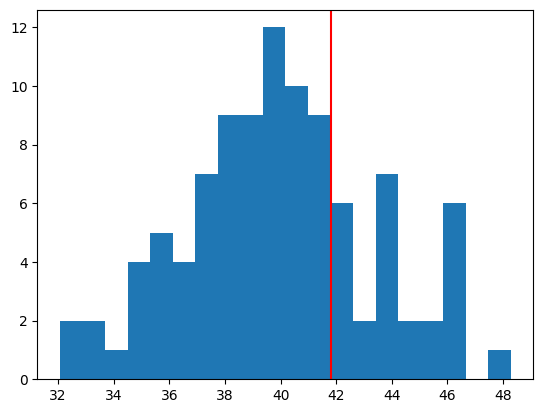

In [43]:
plt.hist(ses, bins = 20)
plt.axvline(most_powerful_pair['se'], color = 'red')
plt.show()